In [5]:
import os
import glob
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv, MessagePassing, TransformerConv
from sklearn.model_selection import train_test_split
import random
from transformers import AutoModelForCausalLM, AutoTokenizer
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import torch.nn as nn
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, auc, roc_auc_score, roc_curve
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [6]:
class GeneEdgeDataset(Dataset):
    def __init__(self, root):
        super().__init__(root)

        self.files = glob.glob(os.path.join(root, '**/*.csv'), recursive=True)

    def len(self):
        return len(self.files)

    def get(self, idx):
        path = self.files[idx]
        df = pd.read_csv(path, sep='\t' if path.endswith('.tsv') else ',')

        genes = pd.unique(df[['Gene1', 'Gene2']].values.ravel())
        id_map = {g: i for i, g in enumerate(genes)}

        edge_index = torch.tensor(
            [[id_map[g] for g in df.Gene1],
             [id_map[g] for g in df.Gene2]],
            dtype=torch.long
        )
        edge_attr = torch.tensor(
            (df.Type == '+').astype(int).values,
            dtype=torch.long
        )

        x = torch.eye(len(genes), dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

        data.id_map = id_map
        data.genes = genes.tolist()
        return data

In [7]:
data_root = '/dataset'
data = GeneEdgeDataset(data_root)

In [8]:
data = torch.load("mcad_deficiency_graph.pth", weights_only=False)

In [9]:
print(f"Graph data loaded: {data}")
print(f"Node features shape: {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Edge attributes shape: {data.edge_attr.shape}")
print(f"Labels: {data.y.unique()}")

Graph data loaded: Data(
  x=[7527, 1],
  edge_index=[2, 8059],
  edge_attr=[8059, 2],
  y=[8059],
  train_mask=[8059],
  test_mask=[8059],
  node_labels=[7527],
  disease_mapping={ mcad_deficiency=1 }
)
Node features shape: torch.Size([7527, 1])
Edge index shape: torch.Size([2, 8059])
Edge attributes shape: torch.Size([8059, 2])
Labels: tensor([0, 1])


In [10]:
def plot_metric(history, metric_name):
    plt.figure(figsize=(8, 5))
    plt.plot(history['epoch'], history[metric_name], label=metric_name)
    plt.xlabel("Epoch")
    plt.ylabel(metric_name.replace("_", " ").title())
    plt.title(f"{metric_name.replace('_', ' ').title()} Over Epochs")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# GCN Model

In [11]:
class GCN(nn.Module):
    def __init__(self, node_feat_dim=1, edge_feat_dim=2, hidden_dim=32):
        super().__init__()
        self.gcn1 = GCNConv(node_feat_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + edge_feat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x, edge_index, edge_attr):
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        src, dst = edge_index
        edge_repr = torch.cat([x[src], x[dst], edge_attr], dim=1)
        return self.mlp(edge_repr)


def evaluate_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'macro_f1': f1_score(y_true, y_pred, average='macro'),
        'weighted_f1': f1_score(y_true, y_pred, average='weighted'),
        'cohen_kappa': cohen_kappa_score(y_true, y_pred),
    }

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

history = {
    'epoch': [],
    'train_loss': [],
    'test_loss': [],
    'accuracy': [],
    'macro_f1': [],
    'weighted_f1': [],
    'cohen_kappa': []
}


print("Epoch | Train Loss | Test Loss | Accuracy | Macro F1 | Weighted F1 | Cohen Kappa")
print("-" * 75)

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    train_loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attr)
        preds = out[data.test_mask].argmax(dim=1)
        true = data.y[data.test_mask]
        test_loss = loss_fn(out[data.test_mask], true).item()
        metrics = evaluate_metrics(true.cpu(), preds.cpu())
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss.item())
        history['test_loss'].append(test_loss)
        history['accuracy'].append(metrics['accuracy'])
        history['macro_f1'].append(metrics['macro_f1'])
        history['weighted_f1'].append(metrics['weighted_f1'])
        history['cohen_kappa'].append(metrics['cohen_kappa'])

    print(f"{epoch:03d}   | {train_loss.item():.4f}     | {test_loss:.4f}   | {metrics['accuracy']:.4f}   "
          f"| {metrics['macro_f1']:.4f}  | {metrics['weighted_f1']:.4f}   | {metrics['cohen_kappa']:.4f}")

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr)
    preds = out[data.test_mask].argmax(dim=1)
    true = data.y[data.test_mask]
    final_test_loss = loss_fn(out[data.test_mask], true).item()
    final_metrics = evaluate_metrics(true.cpu(), preds.cpu())
    final_metrics['test_loss'] = final_test_loss

# Print final summary
print("\nFinal Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

Epoch | Train Loss | Test Loss | Accuracy | Macro F1 | Weighted F1 | Cohen Kappa
---------------------------------------------------------------------------
001   | 0.7672     | 0.6889   | 0.3952   | 0.3658  | 0.3126   | 0.0832
002   | 0.6890     | 0.6167   | 0.8002   | 0.6946  | 0.7646   | 0.4240
003   | 0.6153     | 0.5546   | 0.7091   | 0.4581  | 0.6018   | 0.0638
004   | 0.5524     | 0.5313   | 0.6973   | 0.4186  | 0.5754   | 0.0113
005   | 0.5290     | 0.5101   | 0.6998   | 0.4272  | 0.5811   | 0.0225
006   | 0.5082     | 0.4615   | 0.7364   | 0.5401  | 0.6572   | 0.1797
007   | 0.4597     | 0.4290   | 0.8679   | 0.8185  | 0.8554   | 0.6454
008   | 0.4267     | 0.4104   | 0.9467   | 0.9343  | 0.9454   | 0.8690
009   | 0.4075     | 0.3784   | 0.9578   | 0.9488  | 0.9572   | 0.8977
010   | 0.3752     | 0.3359   | 0.9398   | 0.9249  | 0.9379   | 0.8504
011   | 0.3335     | 0.3042   | 0.9088   | 0.8814  | 0.9036   | 0.7653
012   | 0.3033     | 0.2821   | 0.8970   | 0.8640  | 0.8901   

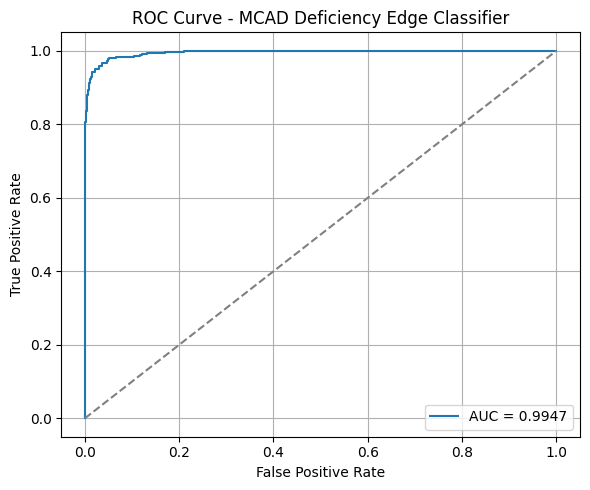

In [12]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr)
    probs = F.softmax(out[data.test_mask], dim=1)[:, 1]
    preds = out[data.test_mask].argmax(dim=1)
    true = data.y[data.test_mask]


    auc_score = roc_auc_score(true.cpu(), probs.cpu())
    fpr, tpr, _ = roc_curve(true.cpu(), probs.cpu())

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - MCAD Deficiency Edge Classifier")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    plt.show()

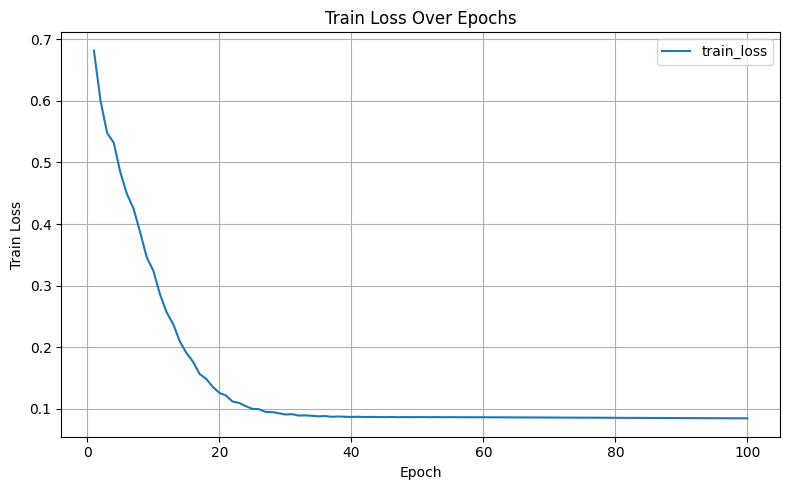

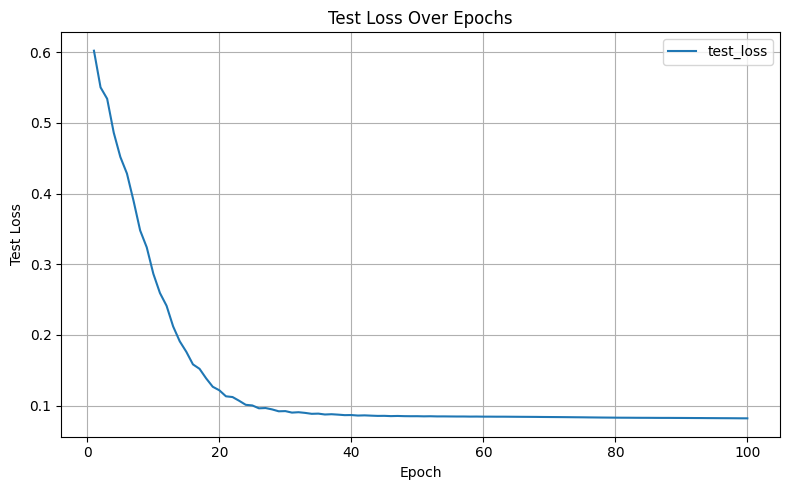

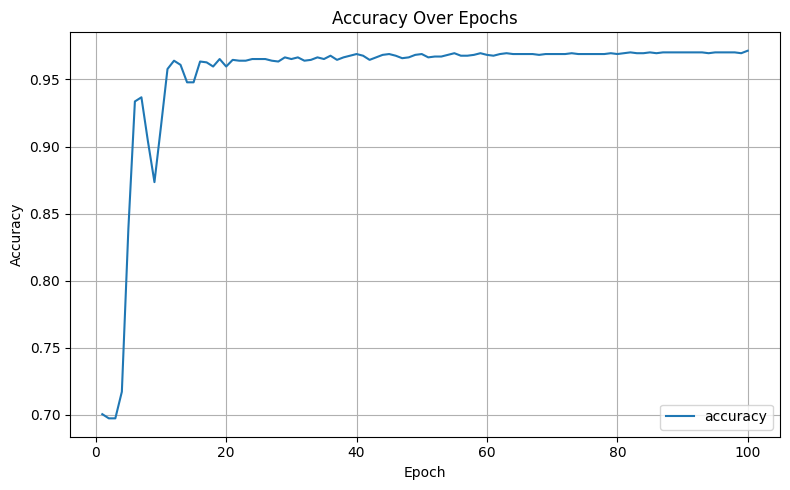

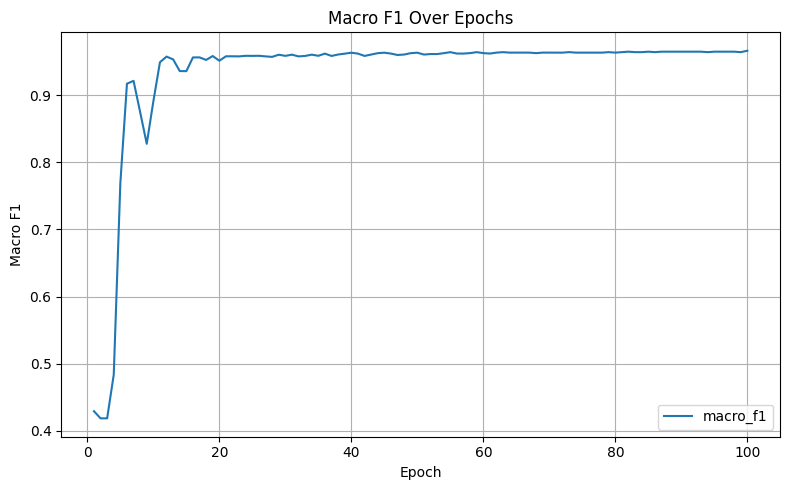

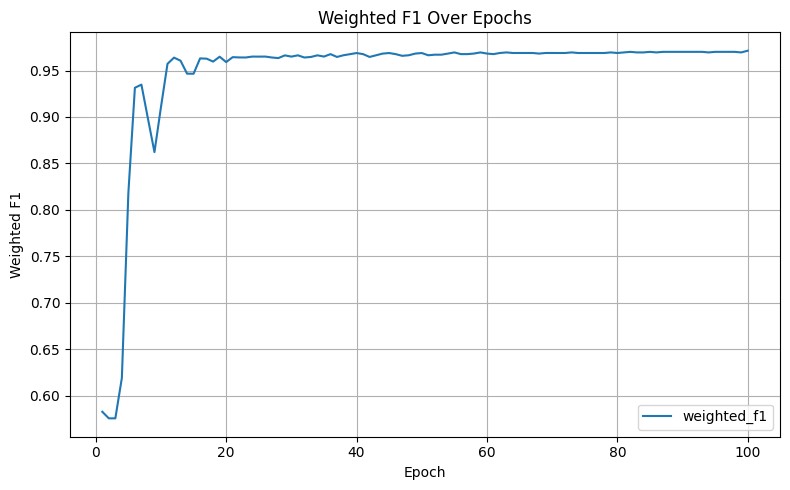

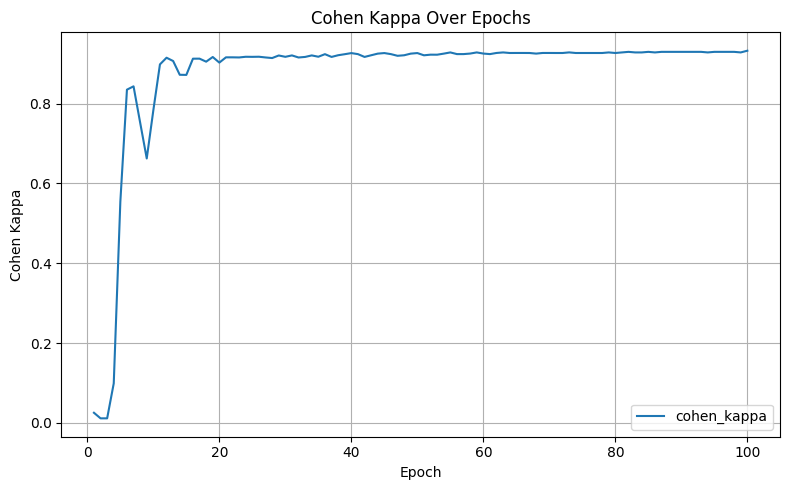

In [9]:
for metric in ['train_loss', 'test_loss', 'accuracy', 'macro_f1', 'weighted_f1', 'cohen_kappa']:
    plot_metric(history, metric)

## CTR-GCN Model

In [13]:
class GCNCTR(nn.Module):
    def __init__(self, node_feat_dim=1, edge_feat_dim=2, hidden_dim=32, dropout=0.5):
        super().__init__()
        self.dropout = dropout

        # Deeper GCN: 4 layers
        self.gcn1 = GCNConv(node_feat_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.gcn3 = GCNConv(hidden_dim, hidden_dim)
        self.gcn4 = GCNConv(hidden_dim, hidden_dim)

        # MLP: Deeper classifier
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + edge_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(p=self.dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x, edge_index, edge_attr):
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        x = F.relu(self.gcn3(x, edge_index))
        x = F.relu(self.gcn4(x, edge_index))

        src, dst = edge_index
        edge_repr = torch.cat([x[src], x[dst], edge_attr], dim=1)
        return self.mlp(edge_repr)

model = GCNCTR()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

history = {
    'epoch': [],
    'train_loss': [],
    'test_loss': [],
    'accuracy': [],
    'macro_f1': [],
    'weighted_f1': [],
    'cohen_kappa': []
}


print("Epoch | Train Loss | Test Loss | Accuracy | Macro F1 | Weighted F1 | Cohen Kappa")
print("-" * 75)

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    train_loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attr)
        preds = out[data.test_mask].argmax(dim=1)
        true = data.y[data.test_mask]
        test_loss = loss_fn(out[data.test_mask], true).item()
        metrics = evaluate_metrics(true.cpu(), preds.cpu())
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss.item())
        history['test_loss'].append(test_loss)
        history['accuracy'].append(metrics['accuracy'])
        history['macro_f1'].append(metrics['macro_f1'])
        history['weighted_f1'].append(metrics['weighted_f1'])
        history['cohen_kappa'].append(metrics['cohen_kappa'])

    print(f"{epoch:03d}   | {train_loss.item():.4f}     | {test_loss:.4f}   | {metrics['accuracy']:.4f}   "
          f"| {metrics['macro_f1']:.4f}  | {metrics['weighted_f1']:.4f}   | {metrics['cohen_kappa']:.4f}")

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr)
    preds = out[data.test_mask].argmax(dim=1)
    true = data.y[data.test_mask]
    final_test_loss = loss_fn(out[data.test_mask], true).item()
    final_metrics = evaluate_metrics(true.cpu(), preds.cpu())
    final_metrics['test_loss'] = final_test_loss

# Print final summary
print("\nFinal Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")


Epoch | Train Loss | Test Loss | Accuracy | Macro F1 | Weighted F1 | Cohen Kappa
---------------------------------------------------------------------------
001   | 0.6794     | 0.6052   | 0.6948   | 0.4100  | 0.5697   | 0.0000
002   | 0.6027     | 0.5240   | 0.6954   | 0.4121  | 0.5711   | 0.0028
003   | 0.5261     | 0.4251   | 0.7531   | 0.5850  | 0.6879   | 0.2471
004   | 0.4342     | 0.3342   | 0.9622   | 0.9543  | 0.9617   | 0.9087
005   | 0.3516     | 0.2323   | 0.9330   | 0.9158  | 0.9306   | 0.8325
006   | 0.2665     | 0.1715   | 0.9646   | 0.9580  | 0.9645   | 0.9160
007   | 0.2038     | 0.1273   | 0.9646   | 0.9579  | 0.9645   | 0.9159
008   | 0.1660     | 0.1033   | 0.9646   | 0.9579  | 0.9644   | 0.9157
009   | 0.1394     | 0.1116   | 0.9597   | 0.9534  | 0.9601   | 0.9069
010   | 0.1308     | 0.0973   | 0.9628   | 0.9552  | 0.9624   | 0.9105
011   | 0.1175     | 0.0905   | 0.9659   | 0.9600  | 0.9660   | 0.9201
012   | 0.1053     | 0.0955   | 0.9665   | 0.9610  | 0.9667   

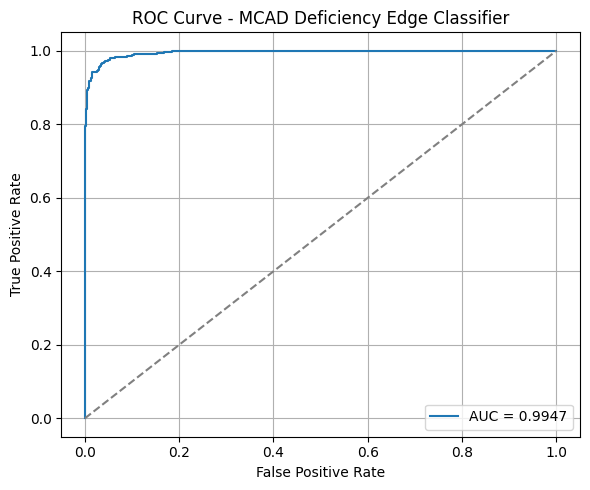

In [14]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr)
    probs = F.softmax(out[data.test_mask], dim=1)[:, 1]
    preds = out[data.test_mask].argmax(dim=1)
    true = data.y[data.test_mask]


    auc_score = roc_auc_score(true.cpu(), probs.cpu())
    fpr, tpr, _ = roc_curve(true.cpu(), probs.cpu())

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - MCAD Deficiency Edge Classifier")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    plt.show()

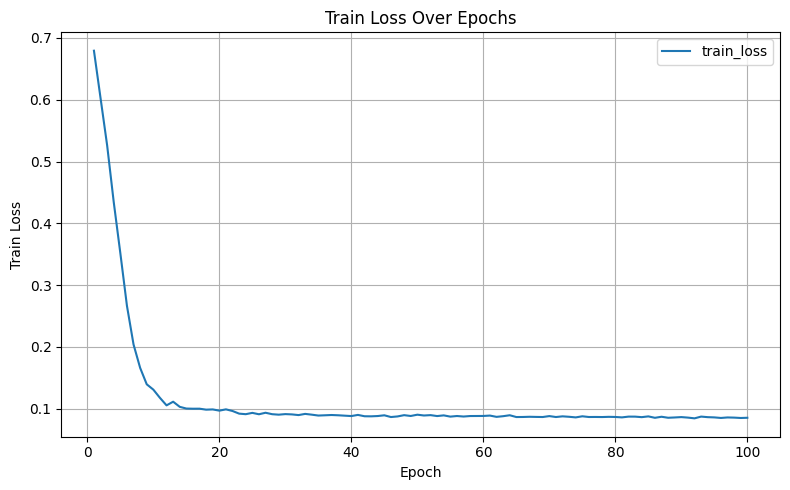

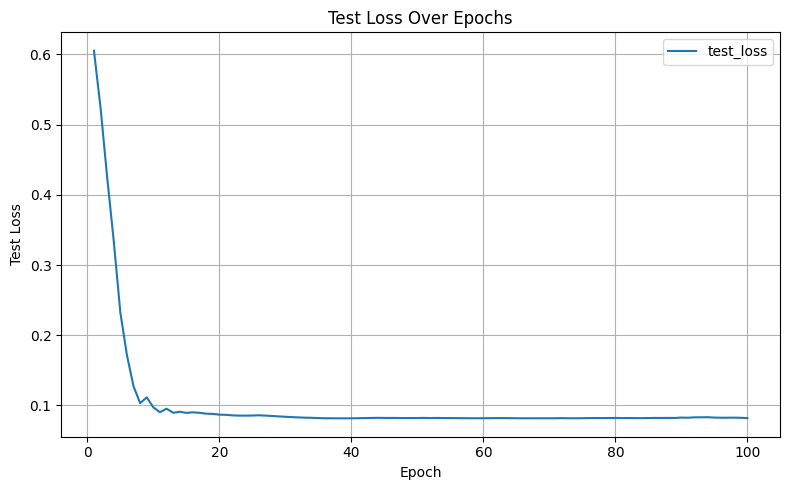

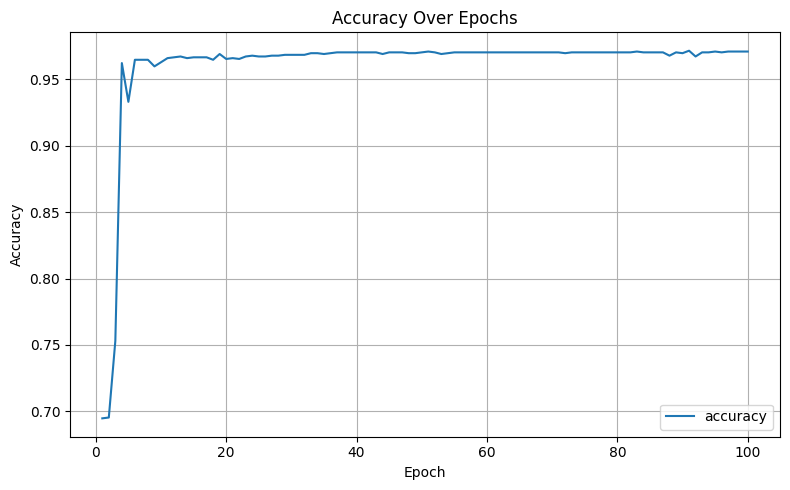

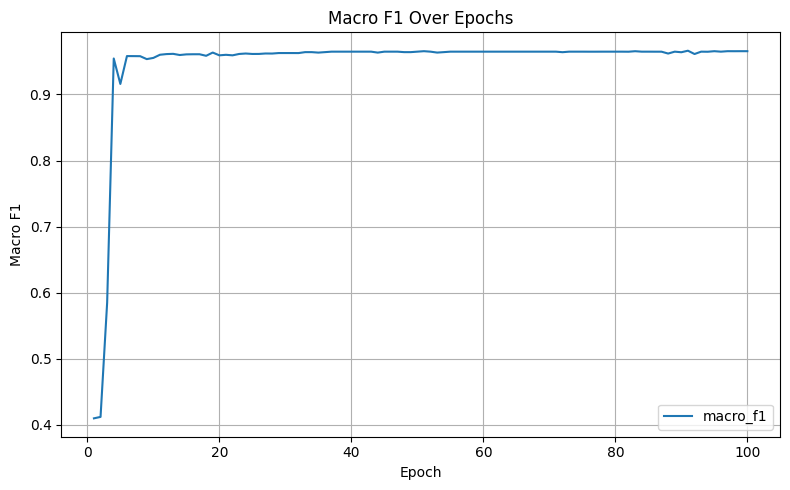

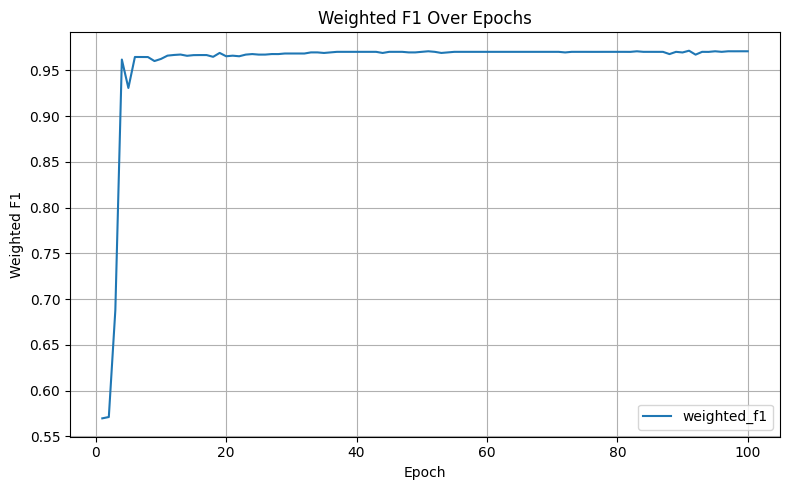

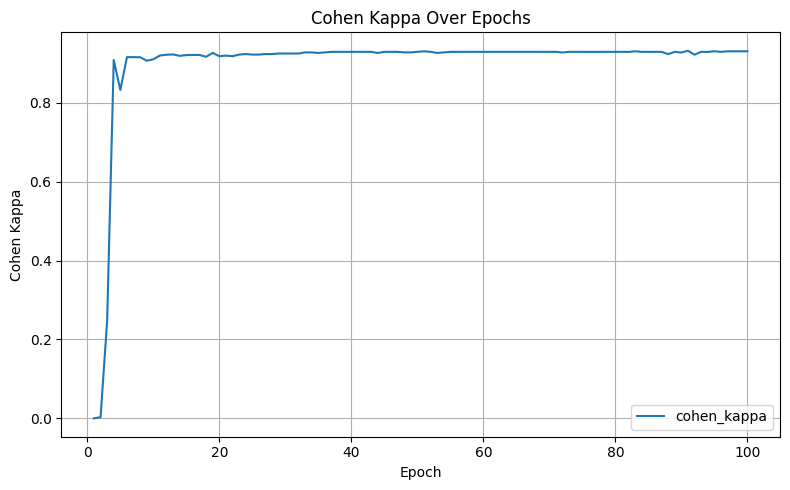

In [15]:
for metric in ['train_loss', 'test_loss', 'accuracy', 'macro_f1', 'weighted_f1', 'cohen_kappa']:
    plot_metric(history, metric)

## LightGCN Model

In [ ]:
class LightGCN(torch.nn.Module):
    def __init__(self, num_nodes, emb_dim, n_layers=3):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_nodes, emb_dim)
        self.n_layers = n_layers
    def forward(self, edge_index):
        x = self.embedding.weight
        embeddings = [x]
        for _ in range(self.n_layers):
            row, col = edge_index
            deg = torch.bincount(row, minlength=x.size(0)).float().pow(-0.5)
            x = deg.unsqueeze(1) * x
            x = torch.zeros_like(embeddings[0]).index_add_(0, col, deg[col].unsqueeze(1) * embeddings[-1][row])
            x = deg.unsqueeze(1) * x
            embeddings.append(x)
        return sum(embeddings) / len(embeddings)


model = LightGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

history = {
    'epoch': [],
    'train_loss': [],
    'test_loss': [],
    'accuracy': [],
    'macro_f1': [],
    'weighted_f1': [],
    'cohen_kappa': []
}


print("Epoch | Train Loss | Test Loss | Accuracy | Macro F1 | Weighted F1 | Cohen Kappa")
print("-" * 75)

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    train_loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attr)
        preds = out[data.test_mask].argmax(dim=1)
        true = data.y[data.test_mask]
        test_loss = loss_fn(out[data.test_mask], true).item()
        metrics = evaluate_metrics(true.cpu(), preds.cpu())
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss.item())
        history['test_loss'].append(test_loss)
        history['accuracy'].append(metrics['accuracy'])
        history['macro_f1'].append(metrics['macro_f1'])
        history['weighted_f1'].append(metrics['weighted_f1'])
        history['cohen_kappa'].append(metrics['cohen_kappa'])

    print(f"{epoch:03d}   | {train_loss.item():.4f}     | {test_loss:.4f}   | {metrics['accuracy']:.4f}   "
          f"| {metrics['macro_f1']:.4f}  | {metrics['weighted_f1']:.4f}   | {metrics['cohen_kappa']:.4f}")

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr)
    preds = out[data.test_mask].argmax(dim=1)
    true = data.y[data.test_mask]
    final_test_loss = loss_fn(out[data.test_mask], true).item()
    final_metrics = evaluate_metrics(true.cpu(), preds.cpu())
    final_metrics['test_loss'] = final_test_loss

# Print final summary
print("\nFinal Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

Epoch | Train Loss | Test Loss | Accuracy | Macro F1 | Weighted F1 | Cohen Kappa
---------------------------------------------------------------------------
001   | 0.7036     | 0.6350   | 0.7543   | 0.5882  | 0.6901   | 0.2520
002   | 0.6336     | 0.5776   | 0.7103   | 0.4621  | 0.6044   | 0.0692
003   | 0.5755     | 0.5259   | 0.7016   | 0.4335  | 0.5853   | 0.0308
004   | 0.5233     | 0.4935   | 0.7010   | 0.4314  | 0.5839   | 0.0280
005   | 0.4914     | 0.4678   | 0.7097   | 0.4601  | 0.6031   | 0.0665
006   | 0.4665     | 0.4225   | 0.7655   | 0.6159  | 0.7093   | 0.2953
007   | 0.4215     | 0.3800   | 0.8716   | 0.8245  | 0.8599   | 0.6567
008   | 0.3784     | 0.3524   | 0.9404   | 0.9259  | 0.9387   | 0.8523
009   | 0.3499     | 0.3272   | 0.9646   | 0.9576  | 0.9644   | 0.9153
010   | 0.3240     | 0.2925   | 0.9659   | 0.9592  | 0.9656   | 0.9185
011   | 0.2894     | 0.2535   | 0.9541   | 0.9439  | 0.9532   | 0.8881
012   | 0.2519     | 0.2280   | 0.9373   | 0.9215  | 0.9352   

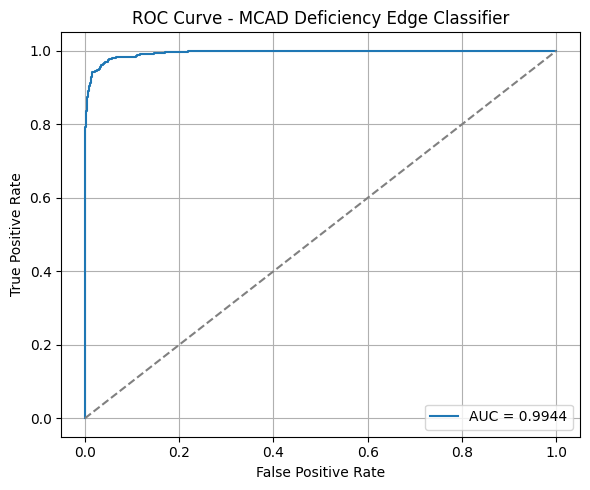

In [17]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr)
    probs = F.softmax(out[data.test_mask], dim=1)[:, 1]
    preds = out[data.test_mask].argmax(dim=1)
    true = data.y[data.test_mask]


    auc_score = roc_auc_score(true.cpu(), probs.cpu())
    fpr, tpr, _ = roc_curve(true.cpu(), probs.cpu())

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - MCAD Deficiency Edge Classifier")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    plt.show()

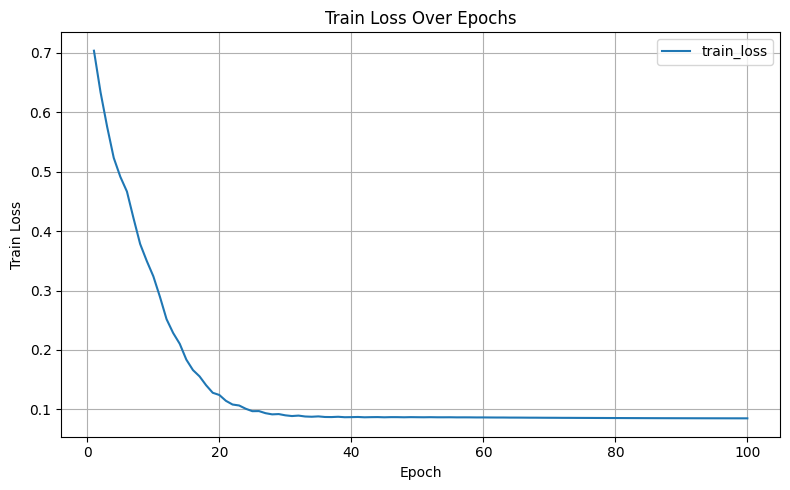

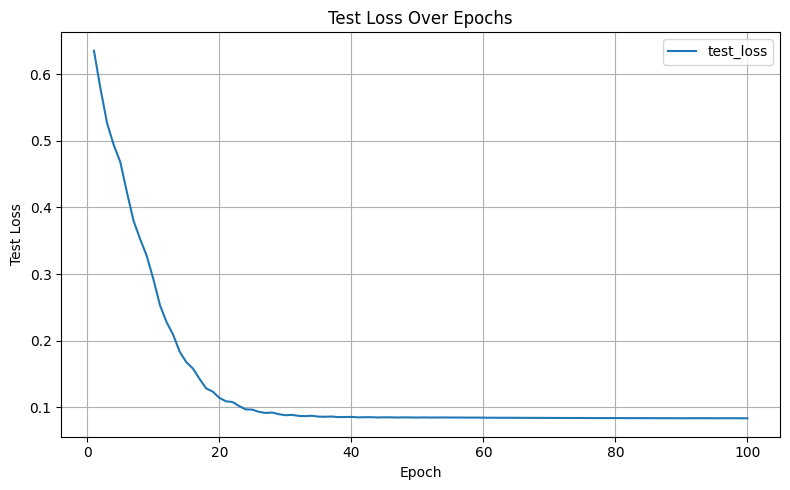

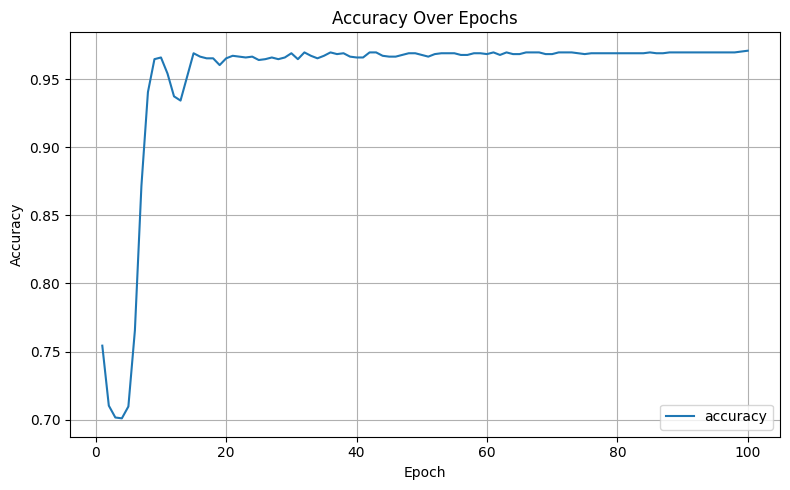

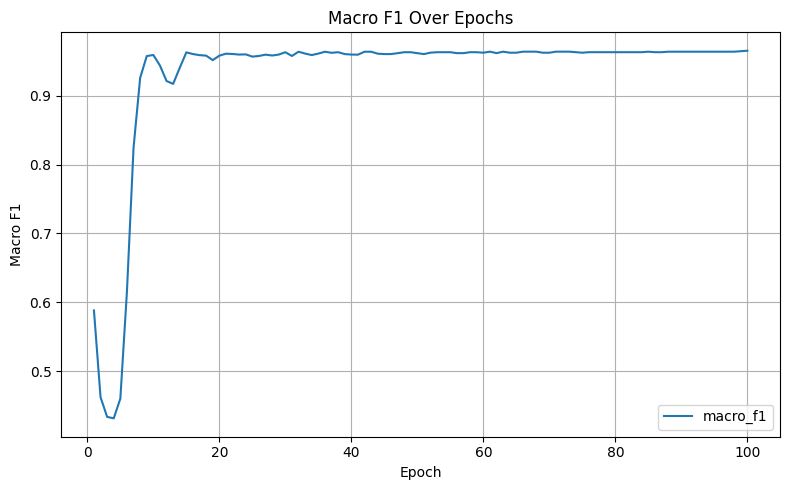

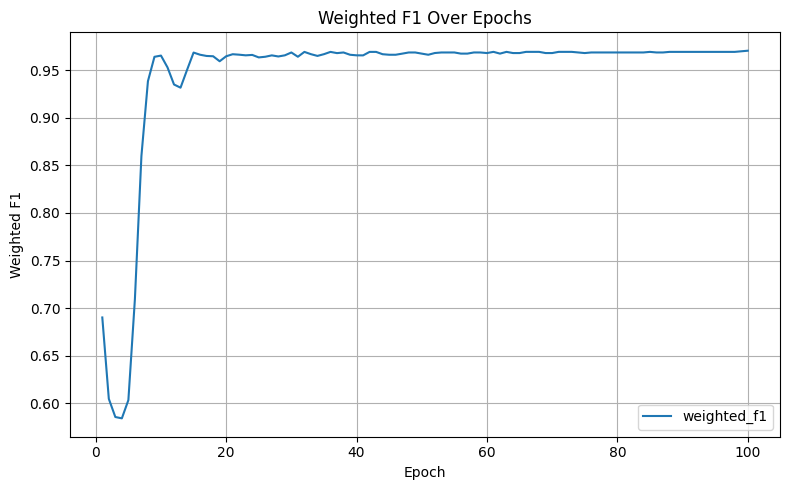

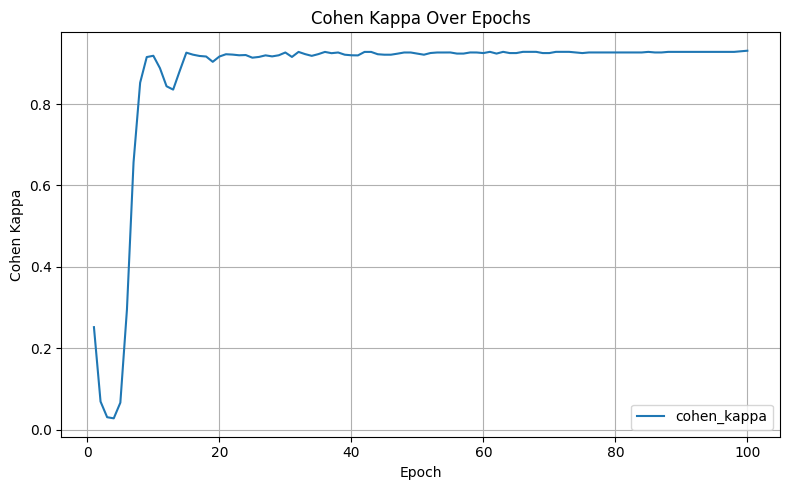

In [18]:
for metric in ['train_loss', 'test_loss', 'accuracy', 'macro_f1', 'weighted_f1', 'cohen_kappa']:
    plot_metric(history, metric)

## LLM way using Transformers

In [ ]:
class LLM(nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(LLM, self).__init__()

        # GCN layers
        self.gcn1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.bn2 = nn.BatchNorm1d(hidden_channels * 2)
        self.gcn3 = GCNConv(hidden_channels * 2, hidden_channels)
        self.bn3 = nn.BatchNorm1d(hidden_channels)

        self.transformer = TransformerConv(hidden_channels, hidden_channels, heads=4)

        self.edge_classifier = nn.Linear(hidden_channels * 8, num_classes)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_attr=None):
        if x.dim() == 1:
            x = x.unsqueeze(1).float()
        else:
            x = x.float()

        x1 = F.leaky_relu(self.bn1(self.gcn1(x, edge_index)))
        x1 = self.dropout(x1)

        x2 = F.leaky_relu(self.bn2(self.gcn2(x1, edge_index)))
        x2 = self.dropout(x2)

        x3 = F.leaky_relu(self.bn3(self.gcn3(x2, edge_index) + x1))

        x3 = self.transformer(x3, edge_index)

        print(f"Shape after transformer: {x3.shape}")

        src, dst = edge_index
        edge_features = torch.cat([x3[src], x3[dst]], dim=1)

        print(f"Shape before classifier: {edge_features.shape}")

        edge_features = edge_features.view(-1, x3.size(1) * 2)


        return F.log_softmax(self.edge_classifier(edge_features), dim=-1)


model = LLM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

history = {
    'epoch': [],
    'train_loss': [],
    'test_loss': [],
    'accuracy': [],
    'macro_f1': [],
    'weighted_f1': [],
    'cohen_kappa': []
}


print("Epoch | Train Loss | Test Loss | Accuracy | Macro F1 | Weighted F1 | Cohen Kappa")
print("-" * 75)

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    train_loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attr)
        preds = out[data.test_mask].argmax(dim=1)
        true = data.y[data.test_mask]
        test_loss = loss_fn(out[data.test_mask], true).item()
        metrics = evaluate_metrics(true.cpu(), preds.cpu())
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss.item())
        history['test_loss'].append(test_loss)
        history['accuracy'].append(metrics['accuracy'])
        history['macro_f1'].append(metrics['macro_f1'])
        history['weighted_f1'].append(metrics['weighted_f1'])
        history['cohen_kappa'].append(metrics['cohen_kappa'])

    print(f"{epoch:03d}   | {train_loss.item():.4f}     | {test_loss:.4f}   | {metrics['accuracy']:.4f}   "
          f"| {metrics['macro_f1']:.4f}  | {metrics['weighted_f1']:.4f}   | {metrics['cohen_kappa']:.4f}")

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr)
    preds = out[data.test_mask].argmax(dim=1)
    true = data.y[data.test_mask]
    final_test_loss = loss_fn(out[data.test_mask], true).item()
    final_metrics = evaluate_metrics(true.cpu(), preds.cpu())
    final_metrics['test_loss'] = final_test_loss

# Print final summary
print("\nFinal Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

Epoch | Train Loss | Test Loss | Accuracy | Macro F1 | Weighted F1 | Cohen Kappa
---------------------------------------------------------------------------
001   | 0.6852     | 0.6253   | 0.7109   | 0.4641  | 0.6058   | 0.0720
002   | 0.6238     | 0.5774   | 0.7047   | 0.4439  | 0.5922   | 0.0446
003   | 0.5754     | 0.5312   | 0.7072   | 0.4520  | 0.5977   | 0.0556
004   | 0.5287     | 0.4948   | 0.7041   | 0.4418  | 0.5909   | 0.0419
005   | 0.4923     | 0.4704   | 0.7097   | 0.4601  | 0.6031   | 0.0665
006   | 0.4685     | 0.4295   | 0.7730   | 0.6337  | 0.7217   | 0.3236
007   | 0.4276     | 0.3984   | 0.9051   | 0.8764  | 0.8996   | 0.7554
008   | 0.3960     | 0.3750   | 0.9498   | 0.9383  | 0.9486   | 0.8768
009   | 0.3721     | 0.3369   | 0.9479   | 0.9356  | 0.9466   | 0.8716
010   | 0.3344     | 0.3007   | 0.9225   | 0.9013  | 0.9191   | 0.8039
011   | 0.2996     | 0.2761   | 0.9138   | 0.8887  | 0.9093   | 0.7795
012   | 0.2763     | 0.2465   | 0.9380   | 0.9223  | 0.9359   

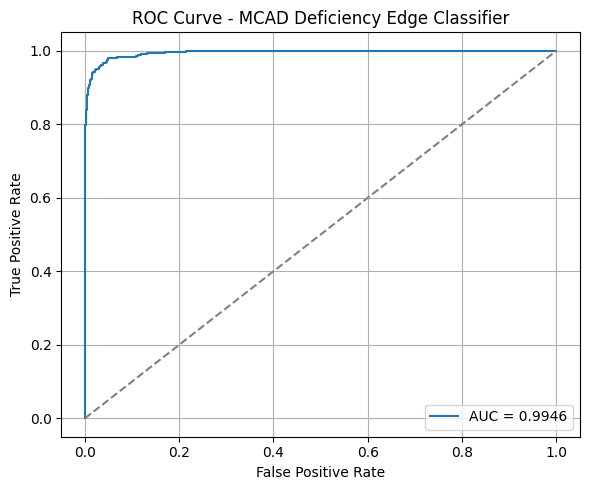

In [21]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr)
    probs = F.softmax(out[data.test_mask], dim=1)[:, 1]
    preds = out[data.test_mask].argmax(dim=1)
    true = data.y[data.test_mask]


    auc_score = roc_auc_score(true.cpu(), probs.cpu())
    fpr, tpr, _ = roc_curve(true.cpu(), probs.cpu())

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - MCAD Deficiency Edge Classifier")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    plt.show()

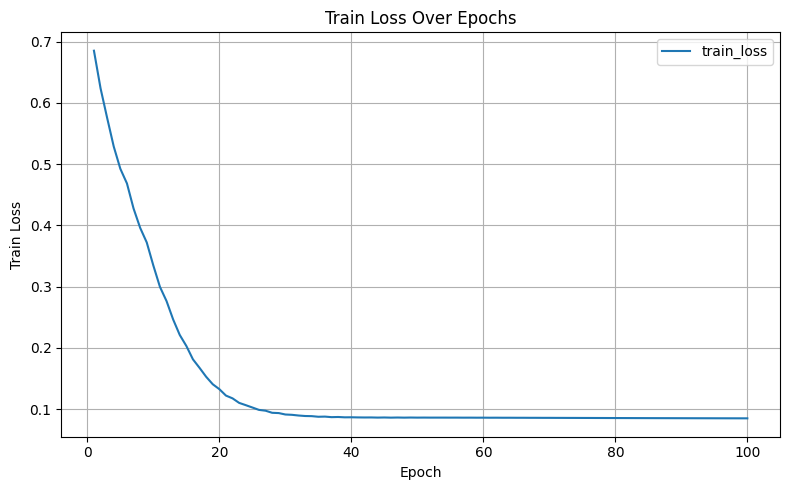

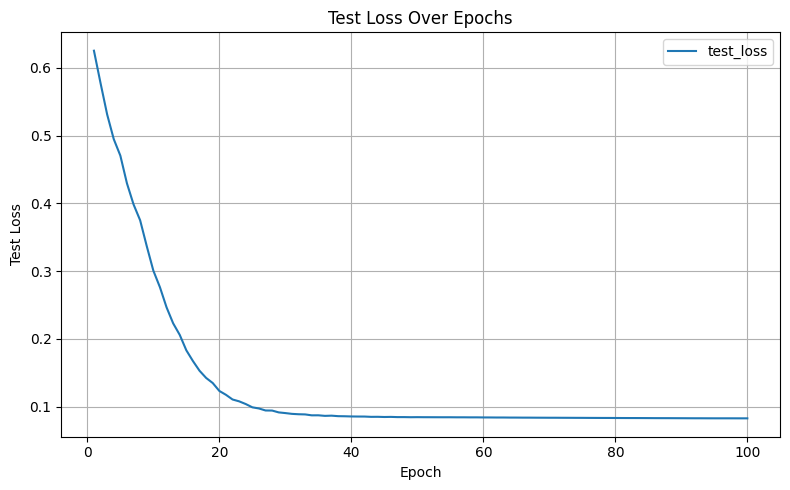

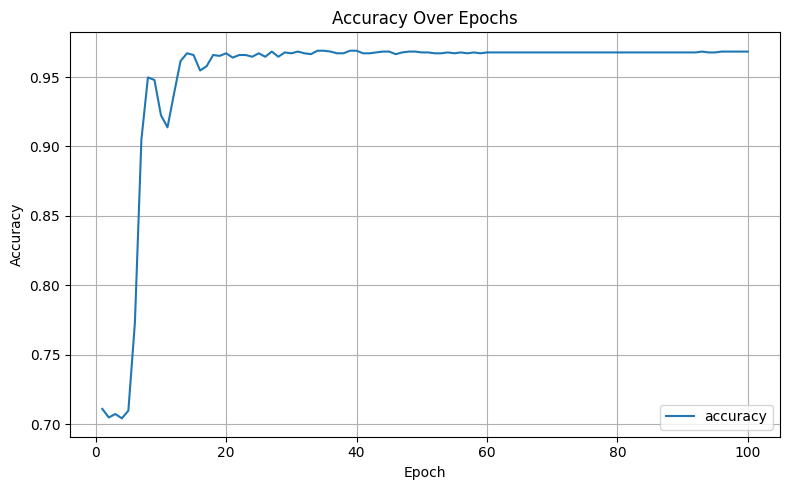

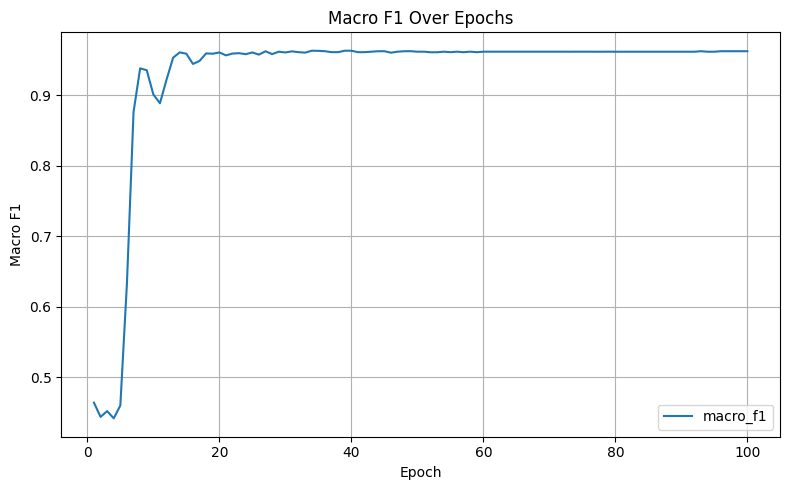

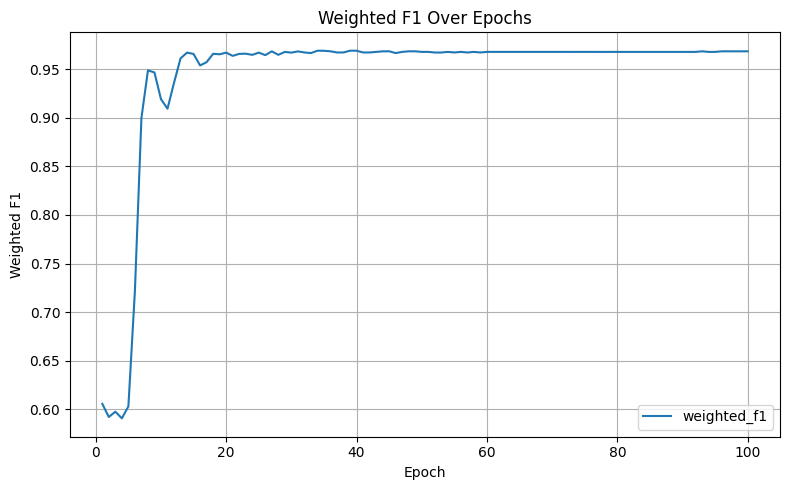

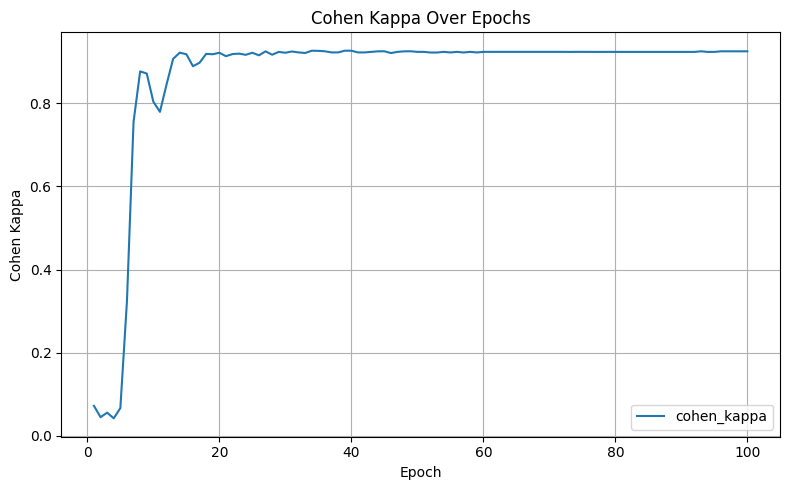

In [22]:
for metric in ['train_loss', 'test_loss', 'accuracy', 'macro_f1', 'weighted_f1', 'cohen_kappa']:
    plot_metric(history, metric)

### PRGNN

In [ ]:
class PRGNN(nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(PRGNN, self).__init__()
        self.gcn1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.bn2 = nn.BatchNorm1d(hidden_channels * 2)
        self.gcn3 = GCNConv(hidden_channels * 2, hidden_channels)
        self.bn3 = nn.BatchNorm1d(hidden_channels)

        self.dropout = nn.Dropout(0.3)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_channels, num_heads=4)
        self.edge_classifier = nn.Linear(hidden_channels * 2, num_classes)

    def forward(self, x, edge_index, edge_attr=None):
        if x.dim() == 1:
            x = x.unsqueeze(1).float()
        else:
            x = x.float()

        x1 = F.leaky_relu(self.bn1(self.gcn1(x, edge_index)))
        x1 = self.dropout(x1)

        x2 = F.leaky_relu(self.bn2(self.gcn2(x1, edge_index)))
        x2 = self.dropout(x2)

        x3 = F.leaky_relu(self.bn3(self.gcn3(x2, edge_index) + x1))

        x3_attn, _ = self.attn(x3.unsqueeze(0), x3.unsqueeze(0), x3.unsqueeze(0))
        x3 = x3_attn.squeeze(0)

        src, dst = edge_index
        edge_features = torch.cat([x3[src], x3[dst]], dim=1)

        return F.log_softmax(self.edge_classifier(edge_features), dim=-1)


model = PRGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

history = {
    'epoch': [],
    'train_loss': [],
    'test_loss': [],
    'accuracy': [],
    'macro_f1': [],
    'weighted_f1': [],
    'cohen_kappa': []
}


print("Epoch | Train Loss | Test Loss | Accuracy | Macro F1 | Weighted F1 | Cohen Kappa")
print("-" * 75)

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    train_loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attr)
        preds = out[data.test_mask].argmax(dim=1)
        true = data.y[data.test_mask]
        test_loss = loss_fn(out[data.test_mask], true).item()
        metrics = evaluate_metrics(true.cpu(), preds.cpu())
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss.item())
        history['test_loss'].append(test_loss)
        history['accuracy'].append(metrics['accuracy'])
        history['macro_f1'].append(metrics['macro_f1'])
        history['weighted_f1'].append(metrics['weighted_f1'])
        history['cohen_kappa'].append(metrics['cohen_kappa'])

    print(f"{epoch:03d}   | {train_loss.item():.4f}     | {test_loss:.4f}   | {metrics['accuracy']:.4f}   "
          f"| {metrics['macro_f1']:.4f}  | {metrics['weighted_f1']:.4f}   | {metrics['cohen_kappa']:.4f}")

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr)
    preds = out[data.test_mask].argmax(dim=1)
    true = data.y[data.test_mask]
    final_test_loss = loss_fn(out[data.test_mask], true).item()
    final_metrics = evaluate_metrics(true.cpu(), preds.cpu())
    final_metrics['test_loss'] = final_test_loss

# Print final summary
print("\nFinal Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")



Epoch | Train Loss | Test Loss | Accuracy | Macro F1 | Weighted F1 | Cohen Kappa
---------------------------------------------------------------------------
001   | 0.7262     | 0.6395   | 0.6948   | 0.4100  | 0.5697   | 0.0000
002   | 0.6385     | 0.5858   | 0.6954   | 0.4121  | 0.5711   | 0.0028
003   | 0.5839     | 0.5492   | 0.6954   | 0.4121  | 0.5711   | 0.0028
004   | 0.5471     | 0.5329   | 0.6967   | 0.4165  | 0.5740   | 0.0085
005   | 0.5310     | 0.5074   | 0.6998   | 0.4272  | 0.5811   | 0.0225
006   | 0.5059     | 0.4713   | 0.7308   | 0.5243  | 0.6464   | 0.1566
007   | 0.4699     | 0.4430   | 0.8288   | 0.7502  | 0.8048   | 0.5210
008   | 0.4413     | 0.4205   | 0.9082   | 0.8807  | 0.9030   | 0.7639
009   | 0.4185     | 0.3904   | 0.9287   | 0.9098  | 0.9259   | 0.8207
010   | 0.3885     | 0.3537   | 0.9200   | 0.8975  | 0.9162   | 0.7966
011   | 0.3525     | 0.3239   | 0.8933   | 0.8584  | 0.8858   | 0.7211
012   | 0.3241     | 0.3003   | 0.8921   | 0.8566  | 0.8844   

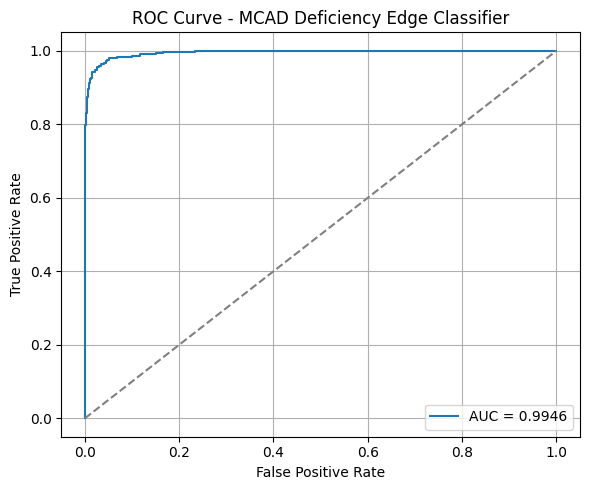

In [24]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr)
    probs = F.softmax(out[data.test_mask], dim=1)[:, 1]
    preds = out[data.test_mask].argmax(dim=1)
    true = data.y[data.test_mask]


    auc_score = roc_auc_score(true.cpu(), probs.cpu())
    fpr, tpr, _ = roc_curve(true.cpu(), probs.cpu())

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - MCAD Deficiency Edge Classifier")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    plt.show()

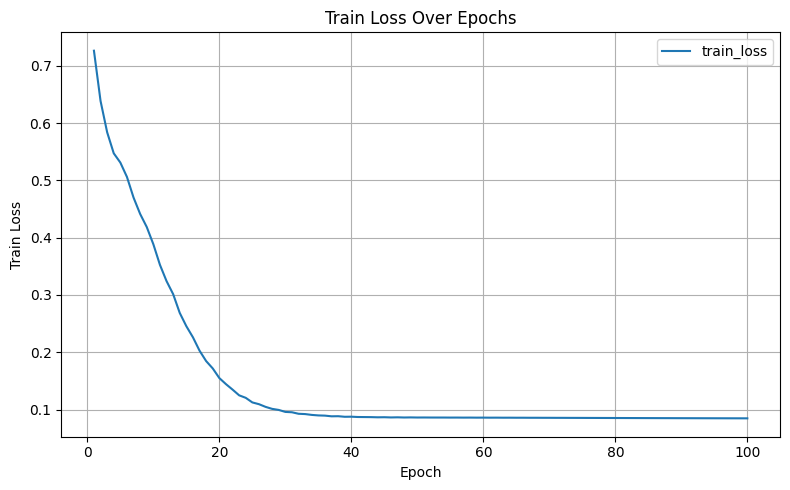

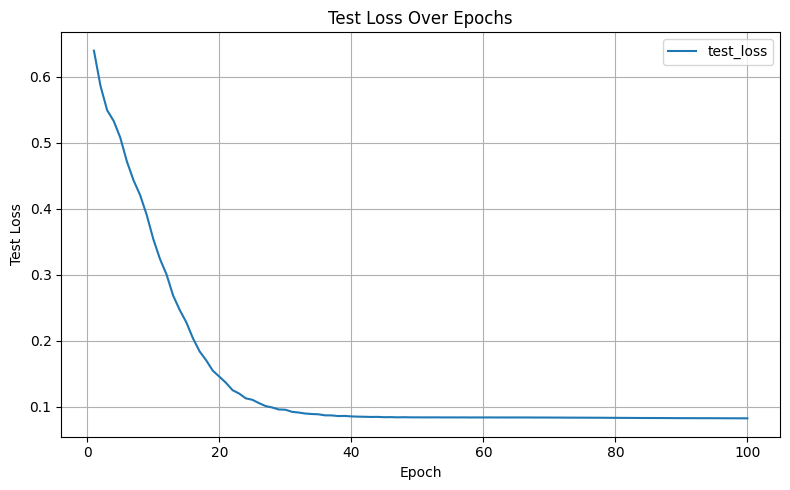

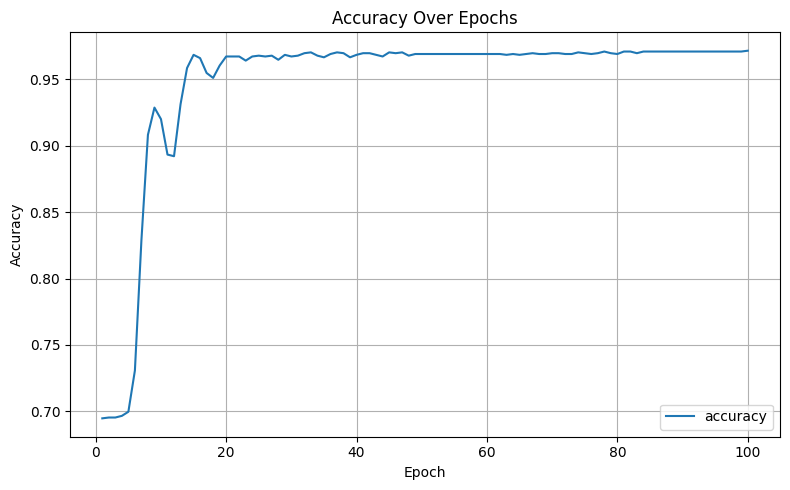

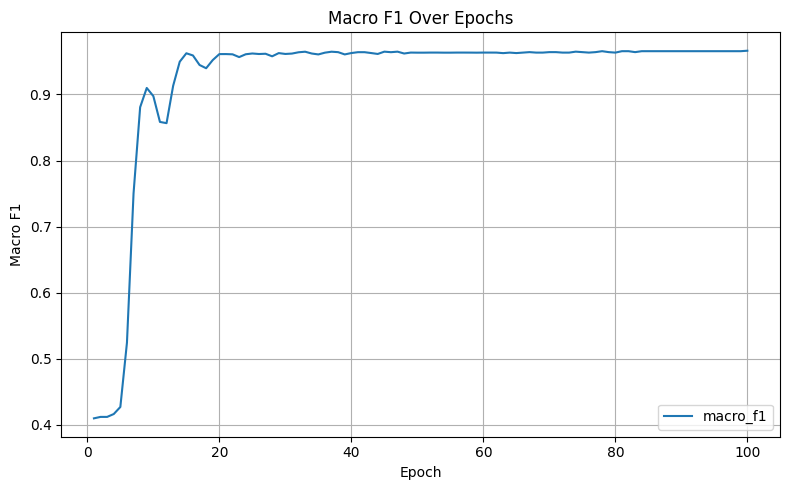

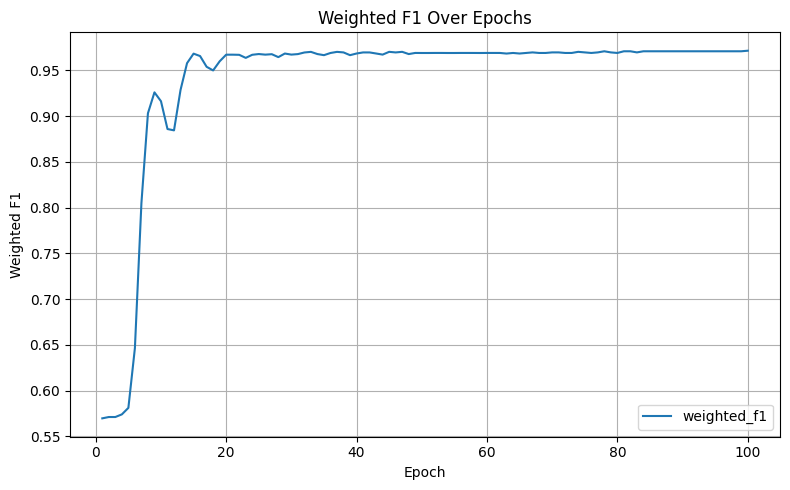

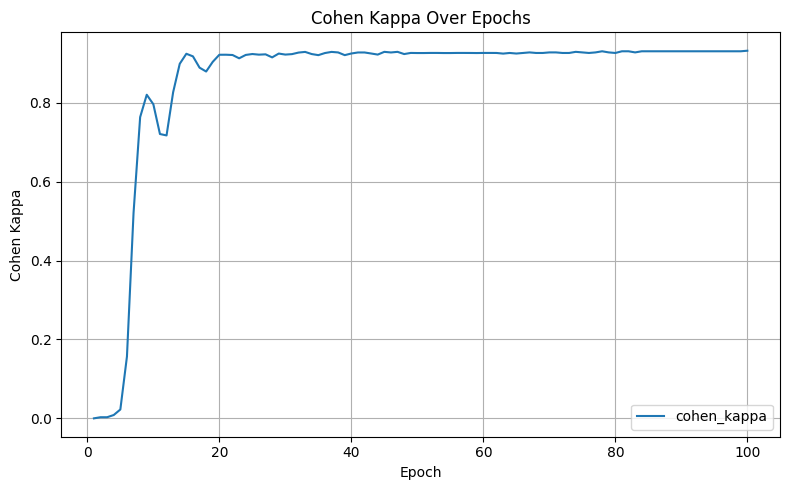

In [25]:
for metric in ['train_loss', 'test_loss', 'accuracy', 'macro_f1', 'weighted_f1', 'cohen_kappa']:
    plot_metric(history, metric)

## GNN

In [ ]:
class GNN(nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels*2)
        self.bn2 = nn.BatchNorm1d(hidden_channels*2)
        self.conv3 = GCNConv(hidden_channels*2, hidden_channels)
        self.bn3 = nn.BatchNorm1d(hidden_channels)
        self.lin = nn.Linear(hidden_channels * 2, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_channels, num_heads=4)

    def forward(self, x, edge_index, edge_attr):
        x = x.unsqueeze(1).float()

        x1 = F.leaky_relu(self.bn1(self.conv1(x, edge_index)))
        x1 = self.dropout(x1)

        x2 = F.leaky_relu(self.bn2(self.conv2(x1, edge_index)))
        x2 = self.dropout(x2)

        x3 = F.leaky_relu(self.bn3(self.conv3(x2, edge_index) + x1))

        x3, _ = self.attention(x3.unsqueeze(0), x3.unsqueeze(0), x3.unsqueeze(0))
        x3 = x3.squeeze(0)

        src, dst = edge_index
        edge_features = torch.cat([x3[src], x3[dst]], dim=1)

        return F.log_softmax(self.lin(edge_features), dim=-1)

model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

history = {
    'epoch': [],
    'train_loss': [],
    'test_loss': [],
    'accuracy': [],
    'macro_f1': [],
    'weighted_f1': [],
    'cohen_kappa': []
}


print("Epoch | Train Loss | Test Loss | Accuracy | Macro F1 | Weighted F1 | Cohen Kappa")
print("-" * 75)

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    train_loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attr)
        preds = out[data.test_mask].argmax(dim=1)
        true = data.y[data.test_mask]
        test_loss = loss_fn(out[data.test_mask], true).item()
        metrics = evaluate_metrics(true.cpu(), preds.cpu())
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss.item())
        history['test_loss'].append(test_loss)
        history['accuracy'].append(metrics['accuracy'])
        history['macro_f1'].append(metrics['macro_f1'])
        history['weighted_f1'].append(metrics['weighted_f1'])
        history['cohen_kappa'].append(metrics['cohen_kappa'])

    print(f"{epoch:03d}   | {train_loss.item():.4f}     | {test_loss:.4f}   | {metrics['accuracy']:.4f}   "
          f"| {metrics['macro_f1']:.4f}  | {metrics['weighted_f1']:.4f}   | {metrics['cohen_kappa']:.4f}")

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr)
    preds = out[data.test_mask].argmax(dim=1)
    true = data.y[data.test_mask]
    final_test_loss = loss_fn(out[data.test_mask], true).item()
    final_metrics = evaluate_metrics(true.cpu(), preds.cpu())
    final_metrics['test_loss'] = final_test_loss

# Print final summary
print("\nFinal Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")


Epoch | Train Loss | Test Loss | Accuracy | Macro F1 | Weighted F1 | Cohen Kappa
---------------------------------------------------------------------------
001   | 0.6667     | 0.5994   | 0.6954   | 0.4121  | 0.5711   | 0.0028
002   | 0.5979     | 0.5376   | 0.6967   | 0.4165  | 0.5740   | 0.0085
003   | 0.5353     | 0.4954   | 0.6998   | 0.4272  | 0.5811   | 0.0225
004   | 0.4932     | 0.4556   | 0.7190   | 0.4893  | 0.6227   | 0.1068
005   | 0.4541     | 0.4074   | 0.8306   | 0.7537  | 0.8073   | 0.5271
006   | 0.4060     | 0.3763   | 0.9311   | 0.9134  | 0.9287   | 0.8277
007   | 0.3744     | 0.3440   | 0.9498   | 0.9383  | 0.9486   | 0.8768
008   | 0.3419     | 0.3034   | 0.9305   | 0.9122  | 0.9278   | 0.8254
009   | 0.3025     | 0.2808   | 0.9020   | 0.8716  | 0.8959   | 0.7463
010   | 0.2819     | 0.2458   | 0.9423   | 0.9283  | 0.9406   | 0.8570
011   | 0.2457     | 0.2274   | 0.9659   | 0.9593  | 0.9657   | 0.9186
012   | 0.2253     | 0.2044   | 0.9690   | 0.9631  | 0.9688   

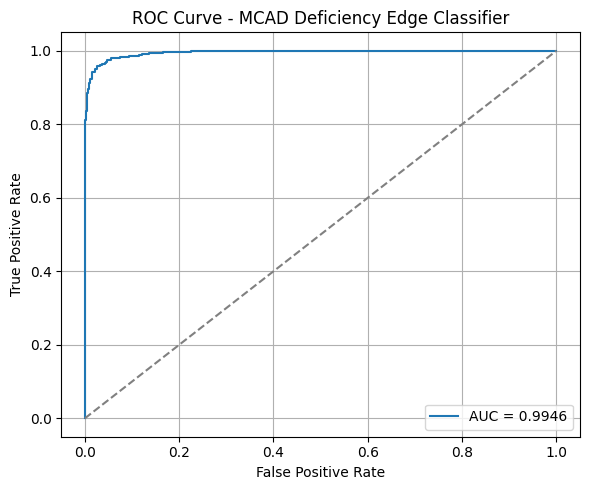

In [27]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr)
    probs = F.softmax(out[data.test_mask], dim=1)[:, 1]
    preds = out[data.test_mask].argmax(dim=1)
    true = data.y[data.test_mask]


    auc_score = roc_auc_score(true.cpu(), probs.cpu())
    fpr, tpr, _ = roc_curve(true.cpu(), probs.cpu())

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - MCAD Deficiency Edge Classifier")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    plt.show()

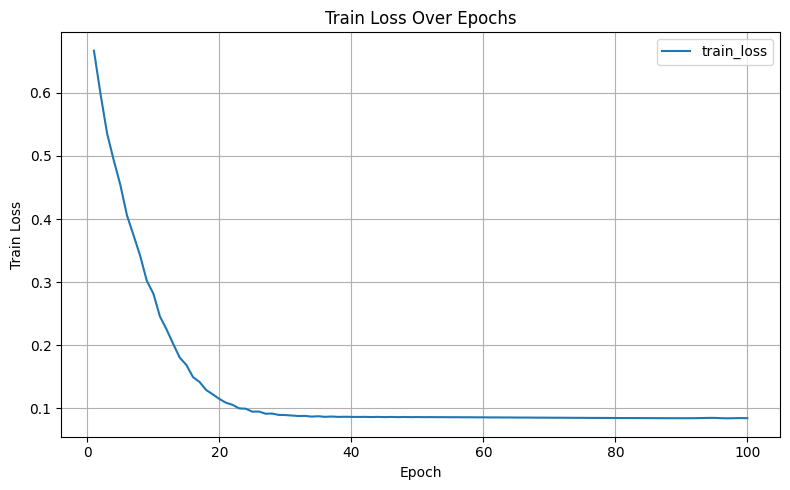

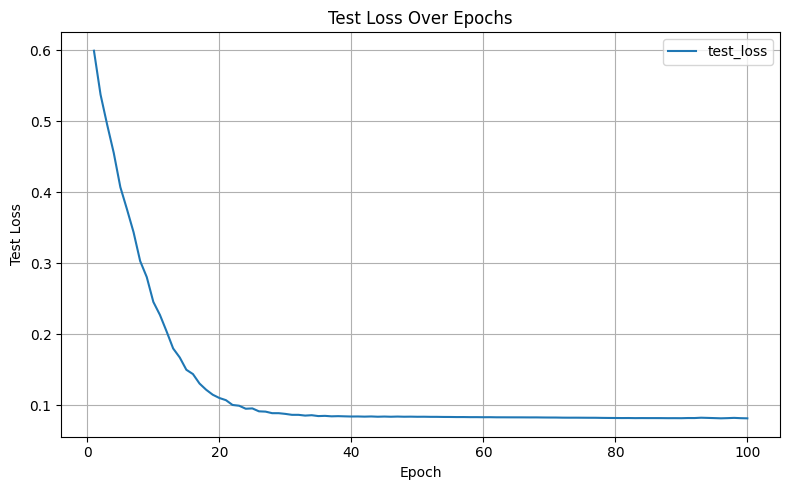

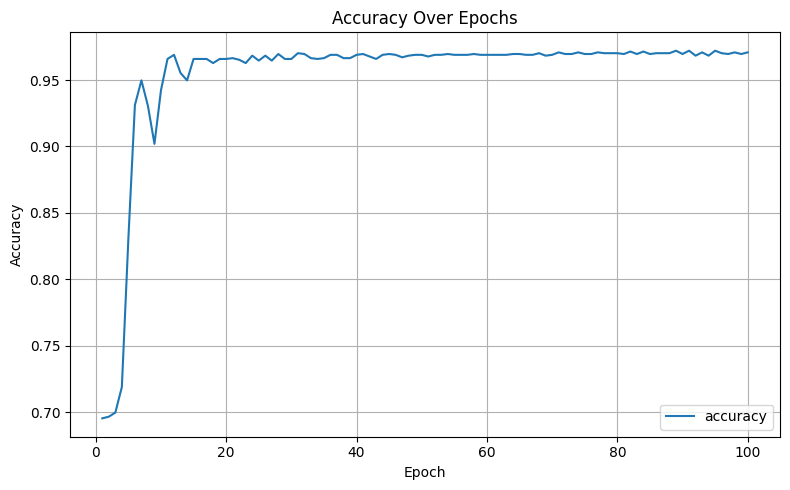

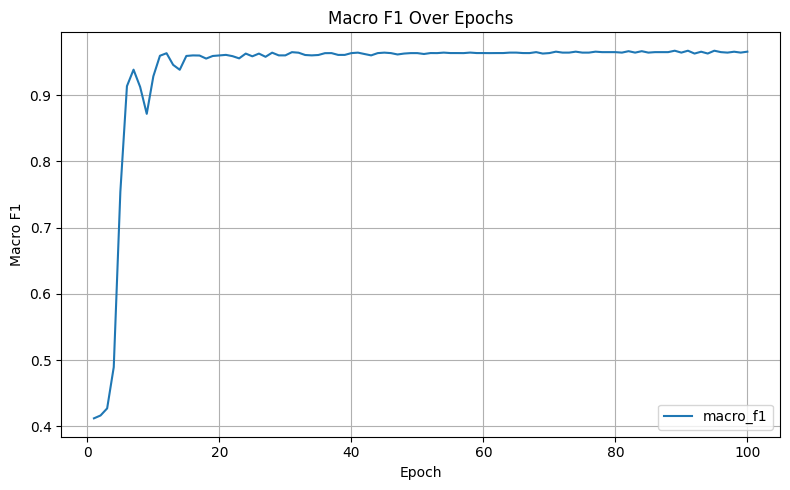

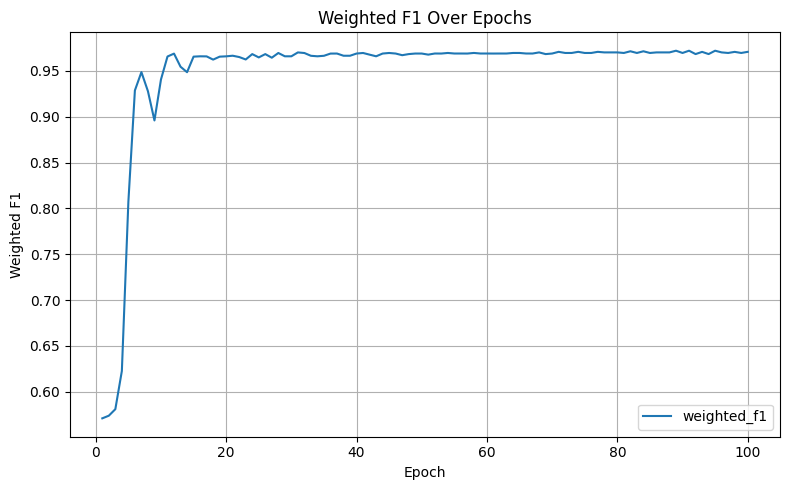

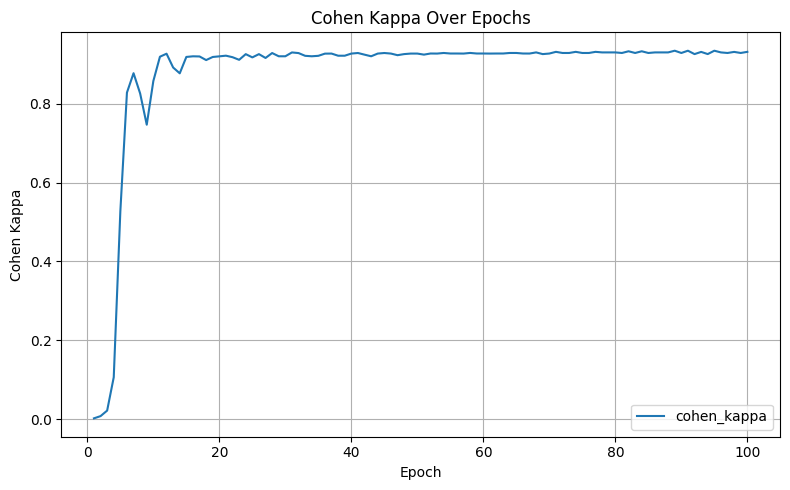

In [28]:
for metric in ['train_loss', 'test_loss', 'accuracy', 'macro_f1', 'weighted_f1', 'cohen_kappa']:
    plot_metric(history, metric)